In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [5]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

def extract_face(image):
  img1 = Image.open(image)            
  img1 = img1.convert('RGB')         
  pixels = asarray(img1)              
  detector = MTCNN()                 
  f = detector.detect_faces(pixels)
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  store_face = pixels[y1:y2,x1:x2]
  plt.imshow(store_face)
  image1 = Image.fromarray(store_face,'RGB')   
  image1 = image1.resize((160,160))             
  face_array = asarray(image1)                  
  return face_array


def load_faces(directory):
  face = []
  i=1
  for filename in listdir(directory):
    path = directory + filename
    faces = extract_face(path)
    face.append(faces)
  return face




In [6]:
def load_dataset(directory):
  x, y = [],[]
  i=1
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    i=i+1
  return asarray(x),asarray(y)  


trainX,trainY = load_dataset('/content/drive/MyDrive/Indian-celebrities/')
print(trainX.shape,trainY.shape)
savez_compressed('/content/drive/MyDrive/PROJECTS/face recog + mood/Indian-celeb-dataset.npz',trainX,trainY)

FileNotFoundError: ignored

## Facenet Model

In [11]:
import numpy as np
from numpy import savez_compressed
from keras.models import load_model 

def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  
  mean = face_pixels.mean()                   
  std  = face_pixels.std()                    
  face_pixels = (face_pixels - mean)/std       
  samples = np.expand_dims(face_pixels,axis=0)    
  yhat = model.predict(samples)
  return yhat[0]

In [13]:
data = np.load('/content/drive/MyDrive/PROJECTS/Indian-celeb-dataset.npz')
trainx, trainy = data['arr_0'],data['arr_1']
print(trainx.shape, trainy.shape)

model = load_model('/content/drive/MyDrive/PROJECTS/facenet_keras.h5')

#get the face embeddings
new_trainx = list()
for train_pixels in trainx:
  embeddings = extract_embeddings(model,train_pixels)
  new_trainx.append(embeddings)
new_trainx = np.asarray(new_trainx)            
print(new_trainx.shape)

#compress the 128 embeddings of each face 
savez_compressed('/content/drive/MyDrive/PROJECTS/Indian-celeb-embeddings.npz',new_trainx,trainy)

(1538, 160, 160, 3) (1538,)
(1538, 128)


Input test data shape:  (1, 160, 160, 3)
Input test embedding shape:  (1, 128)
Loaded data: Train=1538 , Test=1


Text(0.5, 0, 'Predicted Data')

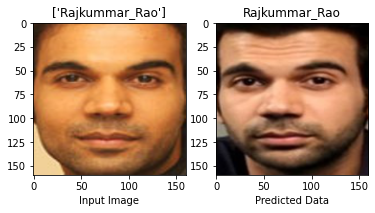

In [19]:
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import array
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
from numpy import reshape
from numpy import load
from numpy import max
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

Img = '/content/drive/MyDrive/rajkummar.jpg'
face = extract_face(Img)
testx = face.reshape(-1,160,160,3)
print("Input test data shape: ",testx.shape)

#find embeddings
model = load_model('/content/drive/MyDrive/PROJECTS/facenet_keras.h5')
new_testx = list()
for test_pixels in testx:
  embeddings = extract_embeddings(model,test_pixels)
  new_testx.append(embeddings)
new_testx = asarray(new_testx)  
print("Input test embedding shape: ",new_testx.shape)

data1 = load('/content/drive/MyDrive/PROJECTS/Indian-celeb-dataset.npz')
train_x,train_y = data1['arr_0'],data1['arr_1']

data = load('/content/drive/MyDrive/PROJECTS/Indian-celeb-embeddings.npz')
trainx,trainy= data['arr_0'],data['arr_1']
print("Loaded data: Train=%d , Test=%d"%(trainx.shape[0],new_testx.shape[0]))

#normalize the input 
in_encode = Normalizer(norm='l2')
trainx = in_encode.transform(trainx)
new_testx = in_encode.transform(new_testx)

#create label vector
out_encode = LabelEncoder()
out_encode.fit(trainy)
trainy = out_encode.transform(trainy)

#svm classifier model 
model =SVC(kernel='linear', probability=True)
model.fit(trainx,trainy)

#predict
predict_train = model.predict(trainx)
predict_test = model.predict(new_testx)

#Accuracy
acc_train = accuracy_score(trainy,predict_train)

#display
trainy_list = list(trainy)
p=int(predict_test)
if p in trainy_list:
  val = trainy_list.index(p)
#display Input Image
plt.subplot(1,2,1)
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)
plt.xlabel("Input Image")
#display Predicated data
plt.subplot(1,2,2)
plt.imshow(train_x[val])
trainy = out_encode.inverse_transform(trainy)
plt.title(trainy[val])
plt.xlabel("Predicted Data")

In [20]:
print(acc_train)

0.9986996098829649


In [22]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/PROJECTS/SVM.sav', 'wb'))

Text(0.5, 1.0, "['Rajkummar_Rao']")

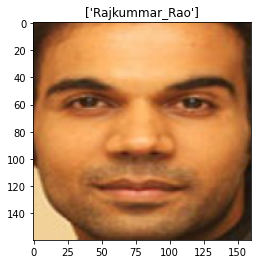

In [25]:
## TESTING
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
loaded_model = pickle.load(open('/content/drive/MyDrive/PROJECTS/SVM.sav', 'rb'))
facenet=load_model('/content/drive/MyDrive/PROJECTS/facenet_keras.h5')
Img = '/content/drive/MyDrive/rajkummar.jpg'
face = extract_face(Img)
testx = face.reshape(-1,160,160,3)
new_testx = list()
for test_pixels in testx:
  embeddings = extract_embeddings(facenet,test_pixels)
  new_testx.append(embeddings)
new_testx = asarray(new_testx)

#ref data for label encoding
data = np.load('/content/drive/MyDrive/PROJECTS/Indian-celeb-embeddings.npz')
trainx,trainy= data['arr_0'],data['arr_1']
out_encode = LabelEncoder()
out_encode.fit(trainy)

in_encode = Normalizer(norm='l2')
new_testx = in_encode.transform(new_testx)
predict_test = loaded_model.predict(new_testx)

plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)

## Mood Predictor 

In [26]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

num_classes=5
img_rows,img_cols=48,48
batch_size=128

train_data_dir='/content/drive/MyDrive/PROJECTS/testing/train'
validation_data_dir='/content/drive/MyDrive/PROJECTS/testing/validation'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        color_mode='grayscale',
                        target_size=(img_rows,img_cols),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                validation_data_dir,
                                color_mode='grayscale',
                                target_size=(img_rows,img_cols),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=True)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [28]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 32)        0

In [32]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('/content/drive/MyDrive/PROJECTS/EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

epochs=25

history=model.fit_generator(
                train_generator,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator)

In [33]:
#TESTING
from keras.models import load_model
import pickle
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)   #warnings are irritating, sorry :P
class_labels=['Angry','Happy','Neutral','Sad','Surprise']

emotdet=load_model('/content/drive/MyDrive/PROJECTS/EmotionDetectionModelV2.h5')


In [34]:
!pip install curtsies

     |████████████████████████████████| 53 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 53 kB 2.1 MB/s 
  Created wheel for curtsies: filename=curtsies-0.3.5-py3-none-any.whl size=35204 sha256=d0652ba18c14f7c635119a6a9e2bdb172c4241ab6d528fac38ec9e10eca477d6
  Stored in directory: /root/.cache/pip/wheels/c0/6c/77/a614cb1e89200fe6f5961e7d8fda95403a69c27ce660ff745b
Successfully built curtsies


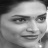

Neutral
##################################################################################


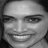

Happy
##################################################################################


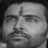

Neutral
##################################################################################


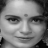

Happy
##################################################################################


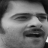

Happy
##################################################################################


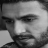

Sad
##################################################################################


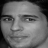

Neutral
##################################################################################


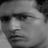

Sad
##################################################################################


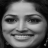

Happy
##################################################################################


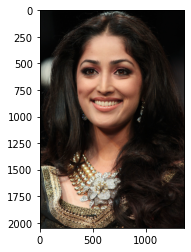

In [38]:
import cv2
from google.colab.patches import cv2_imshow

from curtsies.fmtfuncs import red, green, yellow, blue, cyan
for i in range(1,10):
  Img = f'/content/drive/MyDrive/PROJECTS/testimg/{i}.jpg'
  face = extract_face(Img)
  face=cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  face=cv2.resize(face, (48,48), interpolation = cv2.INTER_AREA)
  cv2_imshow(face)
  face=face.astype('float')/255.0
  face=img_to_array(face)
  face=np.expand_dims(face,axis=0)
  preds=emotdet.predict(face)
  plt.imshow(Image.open(Img))
  pred=preds[0]
  print(cyan(class_labels[pred.argmax()]))
  print('##################################################################################')

# Music recommender

Due to high amount of correlation of features. Only two major emotions come up for song recommendations which are happiness and saddness.

In [39]:
!pip install lightgbm

In [40]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

data=pd.read_csv('/content/drive/MyDrive/PROJECTS/data_spotifyV2.csv')
data.drop_duplicates(inplace=True,subset=['name'])
name=data['name']
col_features = ['danceability', 'energy', 'valence', 'loudness']
X = MinMaxScaler().fit_transform(data[col_features])
kmeans = KMeans(init="k-means++",
                n_clusters=2,
                random_state=15).fit(X)
data['kmeans'] = kmeans.labels_
data['song_name']=name


In [41]:
og_data=data.copy()

In [42]:
cluster=data.groupby(by=data['kmeans'])
y=data.pop('kmeans')
x=data.drop(columns=['name','artists','id','release_date','song_name','id_artists'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
model=LGBMClassifier().fit(x_train,y_train)
model.score(x_train,y_train)

0.9980827579616313

In [43]:
model.score(x_test,y_test)


0.9957623702057893

In [44]:
df=cluster.apply(lambda x: x.sort_values(["popularity"],ascending=False))
df.reset_index(level=0, inplace=True)

In [45]:
EMOTIONS = ["happy","sad"]
  
def get_results(emotion_code, NUM_RECOMMEND=10):
  happy_set=[]
  sad_set=[]
  if emotion_code==0:
      happy_set.append(df[df['kmeans']==0]['song_name'].head(NUM_RECOMMEND))
      return pd.DataFrame(happy_set).T
  else:
      sad_set.append(df[df['kmeans']==1]['song_name'].head(NUM_RECOMMEND))
      return pd.DataFrame(sad_set).T

In [51]:
emotion_word=cyan(class_labels[pred.argmax()])
print(cyan(class_labels[pred.argmax()]))
NUM_RECOMMEND=int(input("Enter number of recommendations: "))
if emotion_word=='sad':
    emotion_code=1
else:
    emotion_code=0
results= get_results(emotion_code,NUM_RECOMMEND)
print(results)

Happy
Enter number of recommendations: 5
                                    song_name
93802  Peaches (feat. Daniel Caesar & Giveon)
93804                  Astronaut In The Ocean
92811                               telepatía
92810                         Save Your Tears
93805                     Leave The Door Open


## To add songs directly to spotify playlist

In [47]:
ids=[]
for x in np.asarray(results):
  print(x)
  ids.append(og_data[og_data['name']==x[0]]['id'])
# ids=np.asarray(ids)

['Peaches (feat. Daniel Caesar & Giveon)']
['Astronaut In The Ocean']
['telepatía']
['Save Your Tears']
['Leave The Door Open']


In [48]:
ids=np.asarray(ids)
ids=ids.ravel()
print(ids)

['4iJyoBOLtHqaGxP12qzhQI' '3Ofmpyhv5UAQ70mENzB277'
 '6tDDoYIxWvMLTdKpjFkc1B' '5QO79kh1waicV47BqGRL3g'
 '7MAibcTli4IisCtbHKrGMh']


In [49]:
from  helpers import *
import spotipy
from spotipy import SpotifyClientCredentials, util
import pandas as pd

client_id='your_client_id'
client_secret='yout_client_secret'
redirect_uri='your_url_to_redirect'

username = 'your_username_code'
scope_playlist = 'playlist-modify-public'
scope_user = 'user-library-modify'
scope_playing = 'user-read-currently-playing'

manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

#Credentiasl to access the Playlists Music
token_playlist= util.prompt_for_user_token(username,scope_playlist,client_id,client_secret,redirect_uri) 
sp_playlist = spotipy.Spotify(auth=token_playlist)


playlist = sp_playlist.user_playlist_create(username,"personal playlist")
sp_playlist.user_playlist_add_tracks(username,playlist,ids)

ModuleNotFoundError: ignored